In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

# import scipy.sparse.linalg
# import numpy as np
import pandas as pd
from numpy import linalg as LA
# from autograd.numpy.linalg import norm

from sklearn.decomposition import PCA
from keras import datasets
from tqdm import tqdm
import matplotlib.pyplot as plt

import autograd.numpy as np

from pymanopt import Problem
from pymanopt.manifolds import Grassmann
from pymanopt.optimizers import SteepestDescent, TrustRegions, line_search
import pymanopt


def PCA_RANSAC(X: np.ndarray, 
               sample_proportion: float=0.68,
                k=50, 
               max_iter=100, 
               outlier_fn=lambda r: np.percentile(r, 98), 
              #  badness_fn=lambda r: np.mean(r)
               ):
  # sample_proportion * data size = subset size
  # k : number of principal components to learn (Grassmannian(d,k), where d=28^2)

  # Initialize variables
  loss = np.inf
  loss_history = []


  # Create the tqdm progress bar
  pbar = tqdm(range(max_iter))
  sample_size = int(X.shape[0] * sample_proportion)

  for i in pbar:
    # Randomly choose indices from the dataset
    random_indices = np.random.choice(X.shape[0], sample_size, replace=False)

    # Extract the corresponding subset of images
    X_subset = X[random_indices]

    pca = PCA(n_components=k)
    pca.fit(X_subset)
    
    # x_i - sum_j <x_i, w_j> w_j
    # pca.components_: k * d matrix
    # x_i: d vector
    # x_i @ pca.components_.T: k vector
    # x_i - x_i @ pca.components_.T @ pca.components_: d vector

    # residual = X_subset - X_subset @ pca.components_.T @ pca.components_
    residual = X - X @ pca.components_.T @ pca.components_

    # projection_loss: n vector
    projection_loss = LA.norm(residual, ord=1, axis=1)

    threshold = outlier_fn(projection_loss)
    X_inlier = X[projection_loss < threshold]
    pca = PCA(n_components=k)
    pca.fit(X_inlier)

    residual = X - X @ pca.components_.T @ pca.components_
    projection_loss = LA.norm(residual, ord=1, axis=1)

    cost: float = projection_loss.mean()
    # cost = sum(projection_loss >= threshold)

    if cost < loss:
      loss = cost
      best_components = pca.components_
      # best_projection_loss = projection_loss
    
    loss_history.append(loss)
    # Update the progress bar with the current loss
    pbar.set_postfix(loss=loss)

#   print("FINAL LOSS", projection_loss.mean())
  final_inlier_threshold = outlier_fn(projection_loss)
  # final_inliers_index = projection_loss < final_inlier_threshold
  final_outliers_index = projection_loss >= final_inlier_threshold

  # Plot the evolution of the loss
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Evolution of Loss')
  plt.show()

  return best_components, final_outliers_index,  #, loss_history


In [2]:
np.random.seed(42)
# Load MNIST dataset (training and test sets) as numpy.ndarray
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Check the shape of the training images: (num_images, height, width)
print(x_train.shape)

X1 = x_train[y_train == 1]
n1 = X1.shape[0]
white_image_proportion = 0.02
n2 = int(white_image_proportion * n1)
noise = np.ones((n2, 28, 28)) * 255

# X = np.concatenate([X1, noise], axis=0)
X = X1

X1 = X1.reshape(-1, 28*28)
mean_X1 = np.mean(X1)
X1 = (X1 - mean_X1)

X = X.reshape(-1, 28*28)
mean_X = np.mean(X)
X = (X - mean_X)

(60000, 28, 28)


100%|██████████| 100/100 [00:14<00:00,  6.84it/s, loss=1.92e+4]


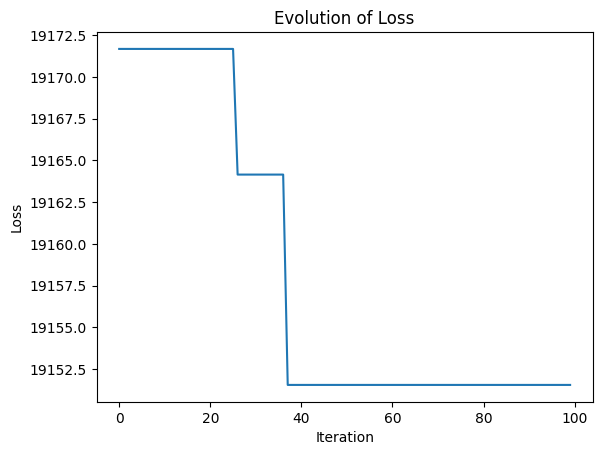

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +1.8577792635647995e+04    2.56406989e+04    
  2          +1.5373896002917838e+04    1.76434289e+04    
  3          +1.3956123467889633e+04    2.80106218e+04    
  4          +9.1802970740990277e+03    1.36376846e+04    
  5          +8.7575220435569991e+03    9.07156018e+03    
  6          +8.6689192454993317e+03    1.27619730e+04    
  7          +8.3996916957954290e+03    6.94374366e+03    
  8          +8.2624239462078149e+03    5.47901706e+03    
  9          +8.1819981806323085e+03    7.50288654e+03    
 10          +8.0610770033034723e+03    6.19793689e+03    
 11          +7.9970049032495153e+03    6.50821009e+03    
 12          +7.9246854069344836e+03    6.87563746e+03    
 13          +7.8859726411101119e+03    7.00169864e+03    
 14          +7.7835410285356074e+03    3.33062792e+03    
 15          +7.7346610103534513e+03    7.

100%|██████████| 100/100 [00:15<00:00,  6.32it/s, loss=1.61e+4]


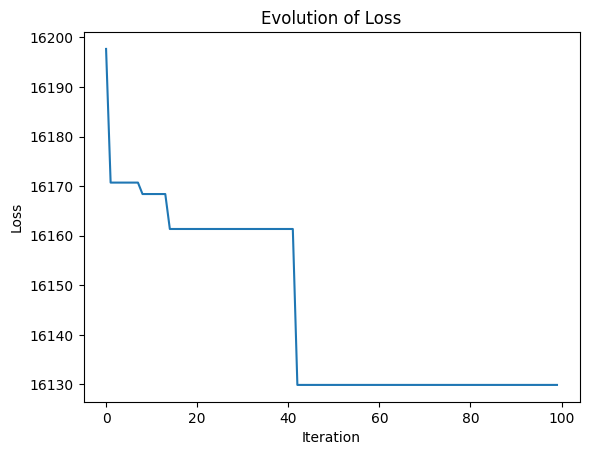

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +1.5822543258638054e+04    2.76183394e+04    
  2          +1.4993079615399738e+04    1.92625175e+04    
  3          +1.1408913444758322e+04    2.22498440e+04    
  4          +7.7440549239111342e+03    2.04698394e+04    
  5          +6.9631177315057757e+03    6.81077150e+03    
  6          +6.8758141680775962e+03    9.17523325e+03    
  7          +6.7212068254318838e+03    5.14886855e+03    
  8          +6.6524058972321309e+03    5.59742191e+03    
  9          +6.5905396175253345e+03    4.80420780e+03    
 10          +6.5503699078260433e+03    5.32042574e+03    
 11          +6.5215694078030992e+03    6.61537435e+03    
 12          +6.4616634262760972e+03    3.21526486e+03    
 13          +6.4529471875543295e+03    7.22884529e+03    
 14          +6.4201338184414190e+03    6.34069612e+03    
 15          +6.3689596241692034e+03    3.

 25%|██▌       | 2/8 [01:23<04:10, 41.77s/it]

Terminated - max iterations reached after 10.47 seconds.



100%|██████████| 100/100 [00:15<00:00,  6.38it/s, loss=1.54e+4]


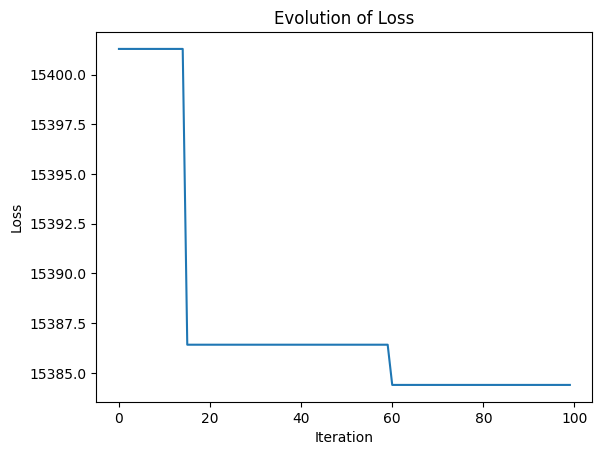

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +1.4808087243537053e+04    2.78610371e+04    
  2          +1.4536278675010917e+04    1.94566475e+04    
  3          +1.3404576825161912e+04    2.10367068e+04    
  4          +8.7231166620076929e+03    2.12632927e+04    
  5          +6.6748073850081000e+03    1.75407500e+04    
  6          +6.4834062006433369e+03    1.41539776e+04    
  7          +6.0232706367755945e+03    4.77749431e+03    
  8          +5.9621866978839416e+03    7.60377270e+03    
  9          +5.8590261074013688e+03    4.50377979e+03    
 10          +5.8166297289128233e+03    4.65049836e+03    
 11          +5.7804771044901199e+03    3.85328125e+03    
 12          +5.7495885617684326e+03    4.30725965e+03    
 13          +5.7415843534889964e+03    5.94178090e+03    
 14          +5.7127867389530293e+03    4.79557457e+03    
 15          +5.6782554595638640e+03    5.

 38%|███▊      | 3/8 [02:04<03:26, 41.20s/it]

149          +3.8813215832325022e+02    6.88033652e+00    
150          +3.8812207590101104e+02    6.94458199e+00    
Terminated - max iterations reached after 10.92 seconds.



100%|██████████| 100/100 [00:18<00:00,  5.43it/s, loss=1.46e+4]


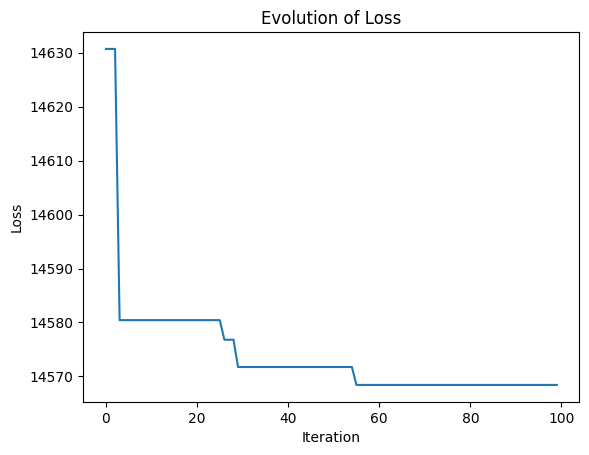

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +1.4070207737474440e+04    2.79765815e+04    
  2          +7.4263207325513076e+03    1.97005264e+04    
  3          +5.9420270174162897e+03    1.45112224e+04    
  4          +5.8959212915614962e+03    1.40047784e+04    
  5          +5.7259163662654673e+03    1.17491455e+04    
  6          +5.4705101461474451e+03    6.69949633e+03    
  7          +5.4036444930127354e+03    6.94934753e+03    
  8          +5.3594444537841418e+03    7.07223103e+03    
  9          +5.2708943680128195e+03    3.76139001e+03    
 10          +5.2351676641013546e+03    5.22868420e+03    
 11          +5.2159896225798029e+03    5.97801766e+03    
 12          +5.1623300506995738e+03    3.08802199e+03    
 13          +5.1313067580377265e+03    6.65608042e+03    
 14          +5.0694826083118360e+03    3.59303443e+03    
 15          +5.0463742084447176e+03    4.

 50%|█████     | 4/8 [02:49<02:50, 42.62s/it]

150          +3.4055250084367412e+02    1.50290533e+01    
Terminated - max iterations reached after 11.54 seconds.



100%|██████████| 100/100 [00:20<00:00,  4.99it/s, loss=1.4e+4]


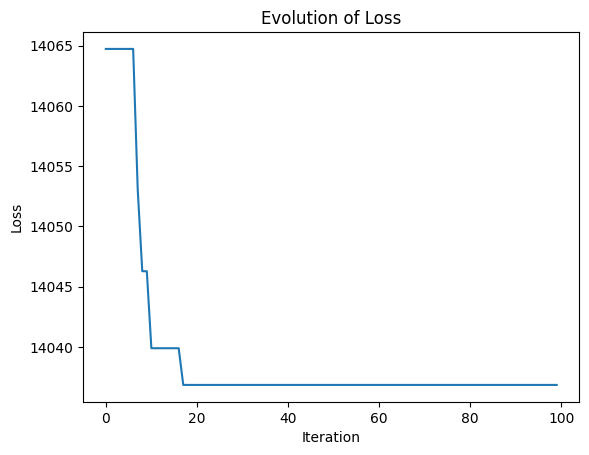

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +1.3310452850503676e+04    2.81966325e+04    
  2          +7.1625729601579169e+03    2.08935576e+04    
  3          +5.3209015978785919e+03    1.04025412e+04    
  4          +5.0725461660565998e+03    5.45791559e+03    
  5          +5.0341398642967470e+03    7.90808621e+03    
  6          +4.9216923227475363e+03    4.27158001e+03    
  7          +4.9147581462733951e+03    6.80508508e+03    
  8          +4.8880849267514332e+03    6.29745454e+03    
  9          +4.8065698646216797e+03    4.54142363e+03    
 10          +4.7606696346953740e+03    5.88977745e+03    
 11          +4.7173656599796896e+03    5.97097868e+03    
 12          +4.6774021445898688e+03    6.29844343e+03    
 13          +4.6415937125450646e+03    5.90618009e+03    
 14          +4.6149442366413969e+03    6.21901338e+03    
 15          +4.5694797405645795e+03    3.

 62%|██████▎   | 5/8 [03:36<02:12, 44.20s/it]

148          +3.0339676775673558e+02    1.07423135e+01    
149          +3.0338520797991549e+02    4.98403033e+00    
150          +3.0335735147996417e+02    1.44711542e+01    
Terminated - max iterations reached after 11.63 seconds.



100%|██████████| 100/100 [00:23<00:00,  4.17it/s, loss=1.21e+4]


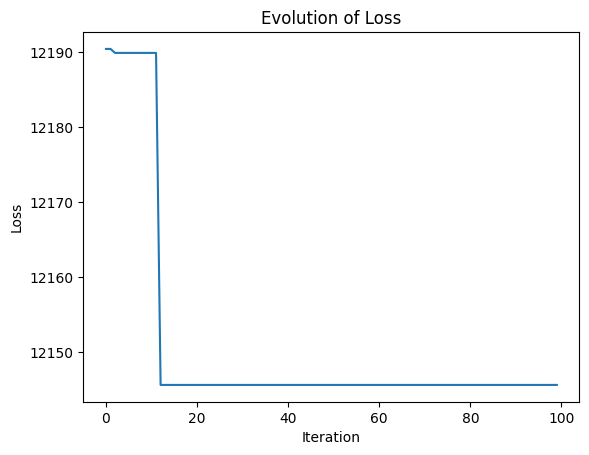

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +1.1342258448237711e+04    2.83473026e+04    
  2          +6.4725171478400525e+03    2.33890530e+04    
  3          +4.3722655113827514e+03    1.96335179e+04    
  4          +4.0161615852890400e+03    1.37269681e+04    
  5          +3.6784102048050809e+03    5.78937513e+03    
  6          +3.6469146103964727e+03    7.09701313e+03    
  7          +3.5737804857122405e+03    3.45411641e+03    
  8          +3.5431948170436208e+03    9.00060855e+03    
  9          +3.4347938279154469e+03    7.13920492e+03    
 10          +3.3417068959211115e+03    5.74858668e+03    
 11          +3.2988727518157843e+03    4.00123780e+03    
 12          +3.2899191818120767e+03    6.40877550e+03    
 13          +3.2590618028557997e+03    4.65575257e+03    
 14          +3.2338249118249614e+03    4.13312080e+03    
 15          +3.2128898300865476e+03    4.

 75%|███████▌  | 6/8 [04:32<01:36, 48.26s/it]

149          +1.9331599986082688e+02    9.27812376e+00    
150          +1.9330529321797559e+02    1.16047013e+01    
Terminated - max iterations reached after 14.32 seconds.



100%|██████████| 100/100 [00:39<00:00,  2.54it/s, loss=9.82e+3]


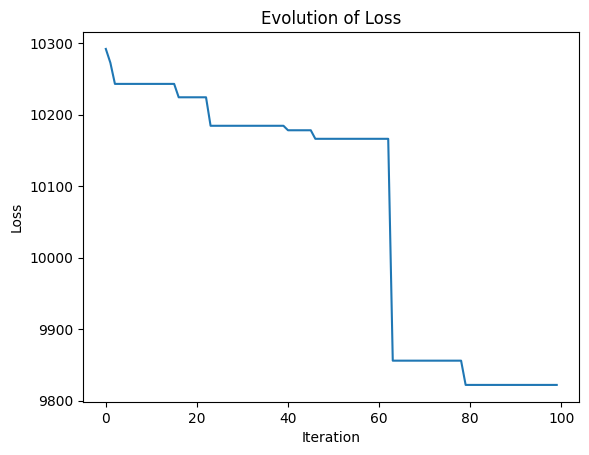

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +9.3038775195635444e+03    2.81687132e+04    
  2          +6.3342798511634956e+03    2.58528229e+04    
  3          +3.3730587598232241e+03    2.30012697e+04    
  4          +2.9188908904456921e+03    1.85956450e+04    
  5          +2.7076796845228741e+03    1.66140866e+04    
  6          +2.2799047942351403e+03    6.32712214e+03    
  7          +2.2358806407712837e+03    5.29927743e+03    
  8          +2.2089637196961908e+03    5.95004708e+03    
  9          +2.1815741504738944e+03    6.39695862e+03    
 10          +2.1499733714433360e+03    6.04807300e+03    
 11          +2.1411149815653434e+03    7.39343957e+03    
 12          +2.1092842285556590e+03    5.85119097e+03    
 13          +2.1080563835451671e+03    7.54070772e+03    
 14          +2.1031959166826264e+03    7.38326549e+03    
 15          +2.0847051052950865e+03    6.

 88%|████████▊ | 7/8 [05:51<00:58, 58.47s/it]

150          +8.1888288017901544e+01    2.63127024e+01    
Terminated - max iterations reached after 18.42 seconds.



100%|██████████| 100/100 [01:47<00:00,  1.08s/it, loss=3.35]


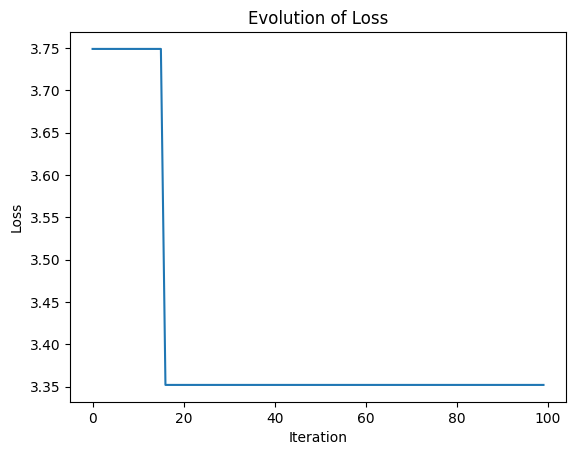

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
  1          +5.1264977888256035e+03    2.31716961e+04    
  2          +2.2485815478910126e+03    1.77488622e+04    
  3          +2.1360179213502424e+03    2.04091843e+04    
  4          +1.7143260174527622e+03    1.79253254e+04    
  5          +1.3812154632417153e+03    1.51967336e+04    
  6          +1.0274682178024502e+03    9.81618912e+03    
  7          +1.0068837917569967e+03    9.95297441e+03    
  8          +9.4614259398983222e+02    5.71947037e+03    
  9          +9.4192056921738492e+02    6.71936915e+03    
 10          +9.2858538216377212e+02    3.75042280e+03    
 11          +9.2464915807978025e+02    7.20375581e+03    
 12          +9.1059519333943717e+02    5.86209199e+03    
 13          +9.0038318867260773e+02    7.53332092e+03    
 14          +8.7598774026051012e+02    5.86192752e+03    
 15          +8.7285434928964708e+02    6.

100%|██████████| 8/8 [08:54<00:00, 66.79s/it]

Terminated - max iterations reached after 35.96 seconds.



In [3]:
data = X  # 10 samples, 5 features

# Define the dimensions
n = data.shape[0]  # Number of rows
d = data.shape[1]  # Number of columns

d_pca = dict()
d_ransac = dict()
d_grassmann_l1 = dict()
d_grassmann_l2 = dict()


for k in tqdm([10, 20, 30, 40, 50, 100, 200, 500]):
    # pca1 = PCA(n_components=k)
    # pca1.fit(X1)

    pca = PCA(n_components=k)
    pca.fit(X)

    residual = X - X @ pca.components_.T @ pca.components_
    projection_loss = LA.norm(residual, ord=1, axis=1)
    threshold = np.quantile(projection_loss, 0.98)

    # R_components, _ = PCA_RANSAC(X, k=k, sample_proportion=0.68, 
    #                              outlier_fn= lambda r: threshold, max_iter=100)
    
    R_components, _ = PCA_RANSAC(X, k=k, sample_proportion=0.68, 
                                 outlier_fn= lambda r: np.quantile(r, 0.98), max_iter=100)

    manifold = Grassmann(d, k)

    # Define the objective function
    @pymanopt.function.autograd(manifold)
    def objective_function(subspace):
        # Project the data onto the subspace
        projection = data @ subspace @ subspace.T 
        # Compute the L1 norm of the difference
        return np.sum(np.abs(data - projection))/n



    # Create the optimization problem
    problem = Problem(manifold=manifold, cost=objective_function)

    # Solve the problem
    # optimizer = TrustRegions(max_iterations =100)
    optimizer = SteepestDescent(max_iterations =150)

    optimal_subspace_l1 = optimizer.run(problem, initial_point=pca.components_.T)

# -----------------------------------------------
    manifold = Grassmann(d, k)

    # Define the objective function
    @pymanopt.function.autograd(manifold)
    def objective_function(subspace):
        # Project the data onto the subspace
        projection = data @ subspace @ subspace.T 
        # Compute the L1 norm of the difference
        residual = data - projection
        output = np.einsum('nd,nd->n', residual, residual)
        output = np.sqrt(output)
        # Compute the L2 norm of the difference  

        return output.sum()/n



    # Create the optimization problem
    problem = Problem(manifold=manifold, cost=objective_function)

    # Solve the problem
    # optimizer = TrustRegions(max_iterations =100)
    optimizer = SteepestDescent(max_iterations =150)

    optimal_subspace_l2 = optimizer.run(problem, initial_point=pca.components_.T)

    d_pca[k] = pca.components_
    d_ransac[k] = R_components
    d_grassmann_l1[k] = optimal_subspace_l1.point.T
    d_grassmann_l2[k] = optimal_subspace_l2.point.T




<Figure size 3600x1800 with 0 Axes>

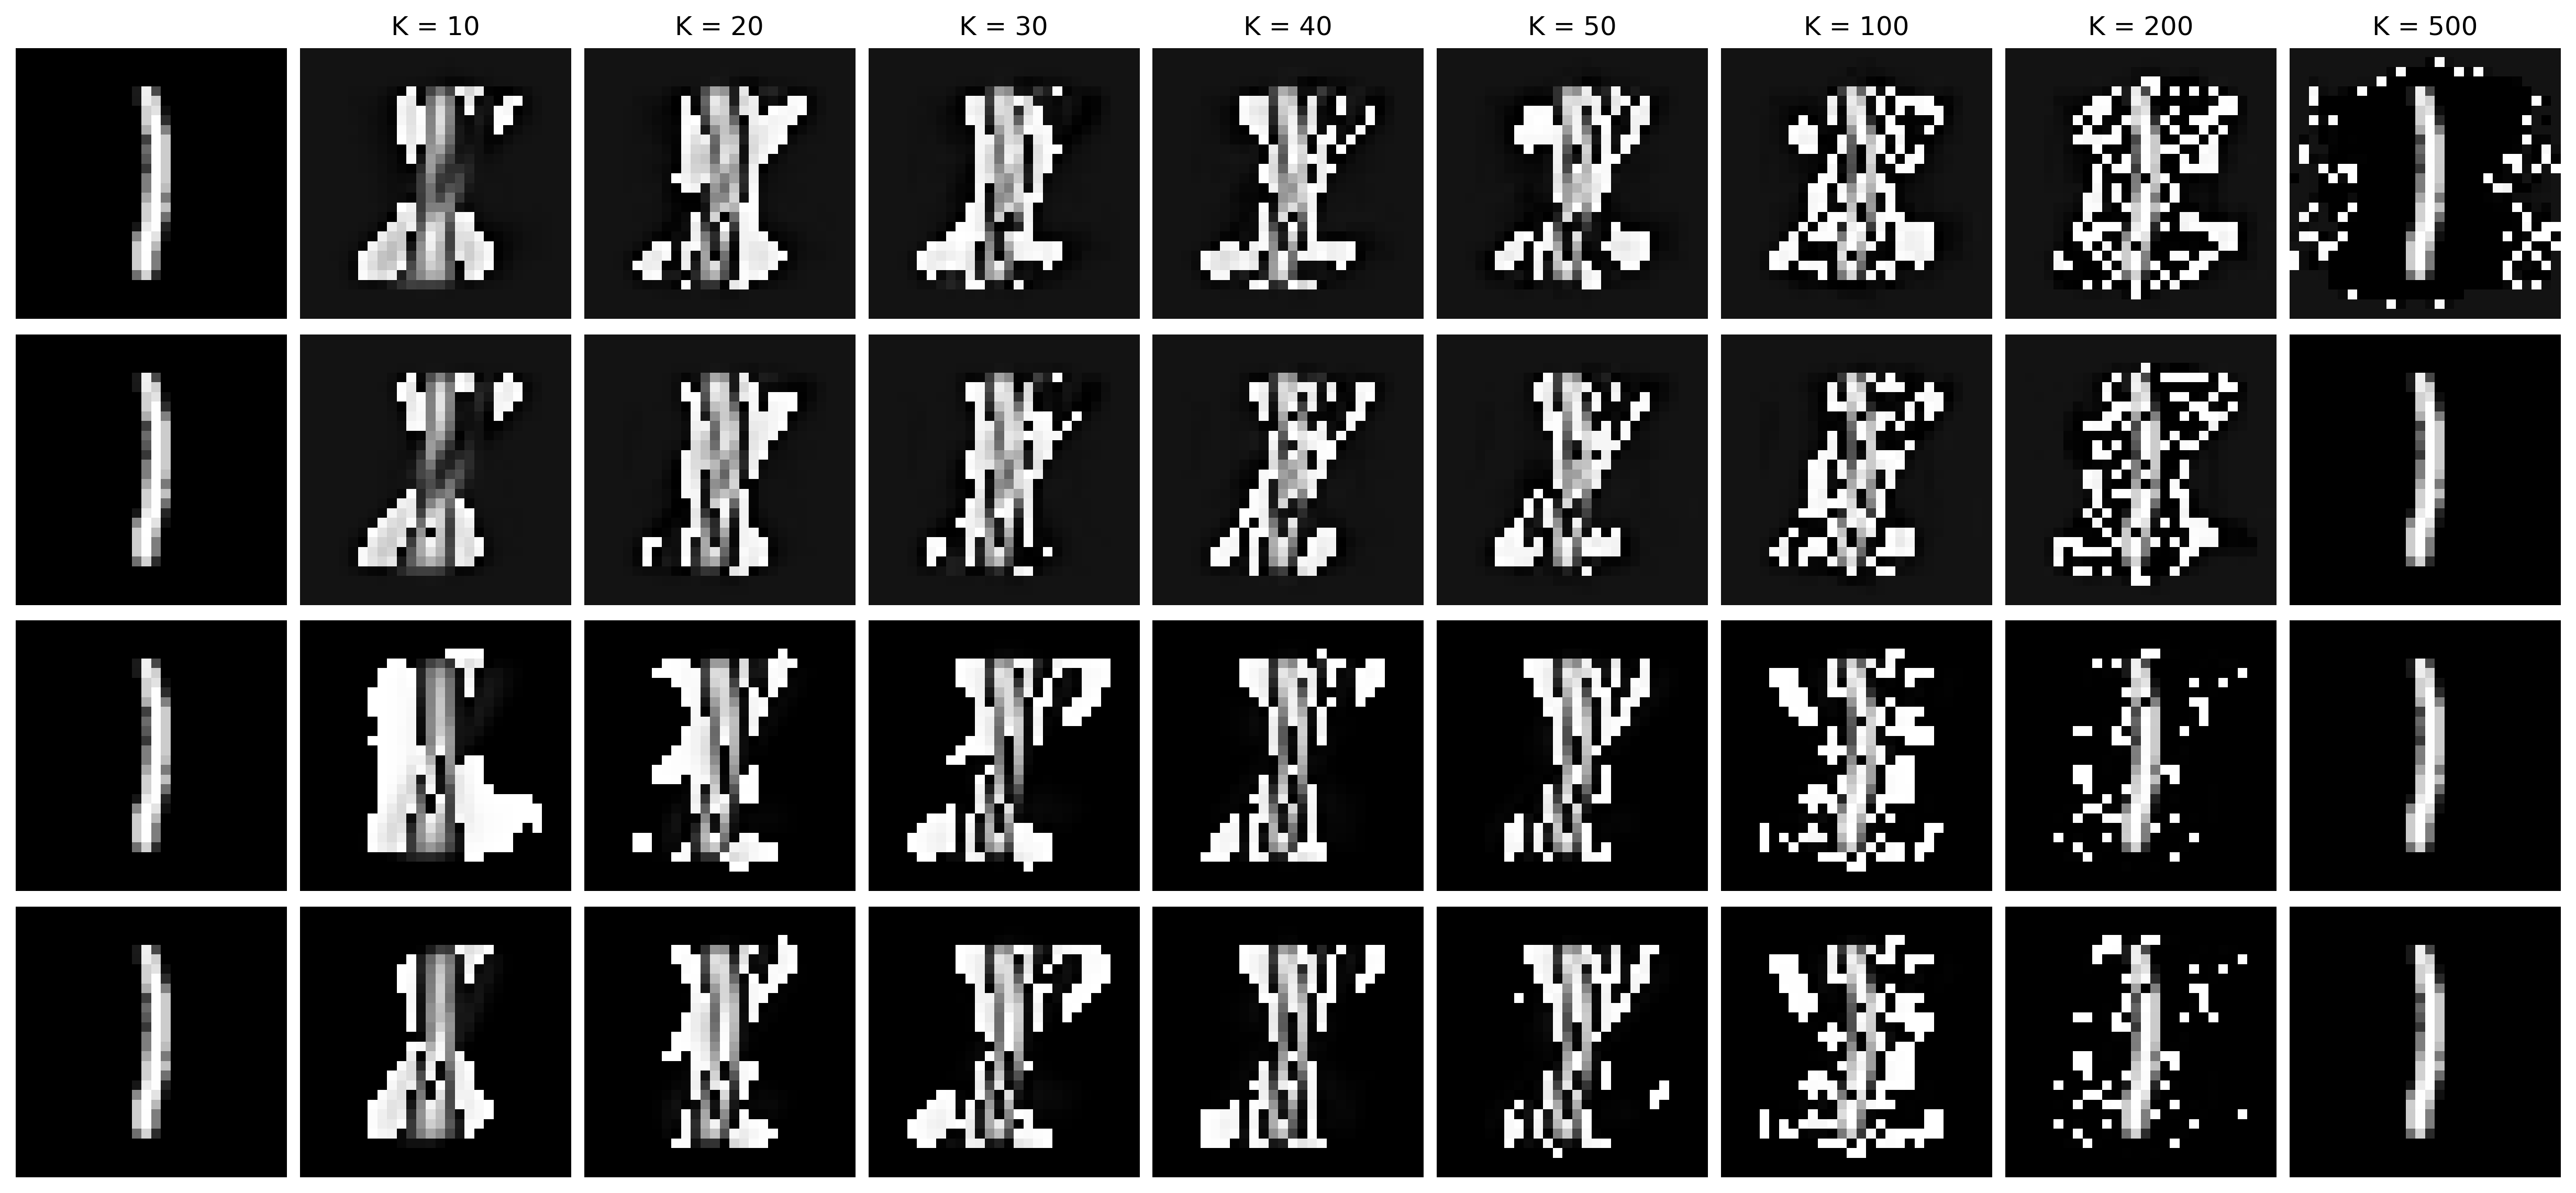

In [4]:
index = 10
x = X1[index] + mean_X1

# Create a figure with high resolution and appropriate size
plt.figure(dpi=300, figsize=(12, 6))  # Adjust figsize as needed
fig, axes = plt.subplots(nrows=4, ncols=9, dpi=300, figsize=(18, 8))

# Original images in the first column
plt.subplot(4, 9, 1)
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(4, 9, 10)
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(4, 9, 19)
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(4, 9, 28)
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

x = X1[index]

# Process other keys
for i, k in enumerate(d_pca.keys()):
    # PCA Reconstruction
    plt.subplot(4, 9, i + 2)
    plt.imshow((x @ d_pca[k].T @ d_pca[k] + mean_X).reshape((28, 28)).astype(np.uint8), cmap='gray')
    plt.axis('off')

    # RANSAC Reconstruction
    plt.subplot(4, 9, i + 11)
    plt.imshow((x @ d_ransac[k].T @ d_ransac[k] + mean_X).reshape((28, 28)).astype(np.uint8), cmap='gray')
    plt.axis('off')

    # Grassmann Reconstruction
    plt.subplot(4, 9, i + 20)
    plt.imshow((x @ d_grassmann_l2[k].T @ d_grassmann_l2[k] + mean_X).reshape((28, 28)).astype(np.uint8), cmap='gray')
    plt.axis('off')

    # Grassmann Reconstruction
    plt.subplot(4, 9, i + 29)
    plt.imshow((x @ d_grassmann_l1[k].T @ d_grassmann_l1[k] + mean_X).reshape((28, 28)).astype(np.uint8), cmap='gray')
    plt.axis('off')

# Tighten the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Optional: Use tight_layout for automatic adjustment (uncomment if needed)
# plt.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)

# Save the figure with high resolution (optional)
# plt.savefig('output.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
cols = [f'K = {k}' for k in d_pca.keys()]
rows = ['PCA', 'RANSAC', 'Grassmann']

for ax, col in zip(axes[0, 1:], cols):
    ax.set_title(col)

# for ax, row in zip(axes[:,0], rows):
#     ax.set_ylabel(row, rotation=0, size='large')

plt.show()

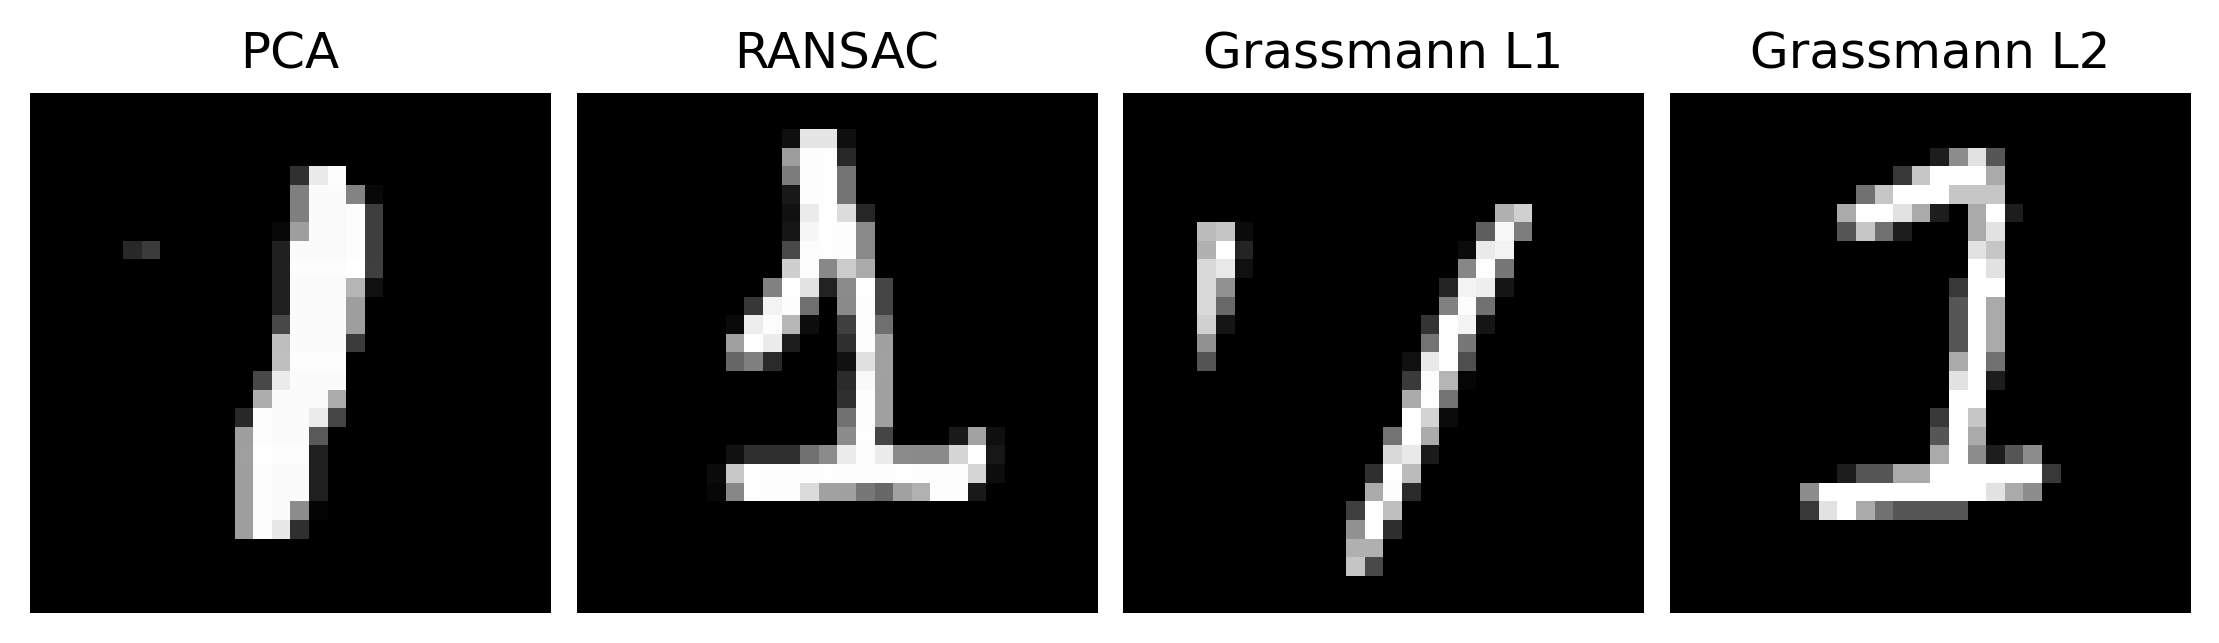

In [5]:
pca_components = d_pca[500]
grassmann_components_l1 = d_grassmann_l1[500]
R_components = d_ransac[500]
grassmann_components_l2 = d_grassmann_l2[500]

outlier_threshold = 0.9999
population_loss = LA.norm((X1 + mean_X1 - (X1 @ pca_components.T @ pca_components + mean_X).astype(np.uint8)), axis=1, ord=1)
q = np.quantile(population_loss, outlier_threshold)
pca_index = np.where(population_loss > q)[0][-1]

population_loss = LA.norm((X1 + mean_X1 - (X1 @ R_components.T @ R_components + mean_X).astype(np.uint8)), axis=1, ord=1)
q = np.quantile(population_loss, outlier_threshold)
r_index = np.where(population_loss > q)[0][-1]

population_loss = LA.norm((X1 + mean_X1 - (X1 @ grassmann_components_l1.T @ grassmann_components_l1 + mean_X).astype(np.uint8)), axis=1, ord=1)
q = np.quantile(population_loss, outlier_threshold)
l1_index = np.where(population_loss > q)[0][-1]

population_loss = LA.norm((X1 + mean_X1 - (X1 @ grassmann_components_l2.T @ grassmann_components_l2 + mean_X).astype(np.uint8)), axis=1, ord=1)
q = np.quantile(population_loss, outlier_threshold)
l2_index = np.where(population_loss > q)[0][-1]


fig, axes = plt.subplots(nrows=1, ncols=4, dpi=300, figsize=(8, 2))
# Original images in the first column
plt.subplot(1, 4, 1)
x = X1[pca_index] + mean_X1
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
x = X1[r_index] + mean_X1
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
x = X1[l1_index] + mean_X1
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
x = X1[l2_index] + mean_X1
plt.imshow((x).reshape((28, 28)).astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)


cols = ['PCA', 'RANSAC', 'Grassmann L1', 'Grassmann L2']

for ax, col in zip(axes, cols):
    ax.set_title(col)